#Pobranie i instalacja odpowiednich bibliotek

In [ ]:
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2

# instalacja spaCy
!python3 -m pip install spacy

# 1. instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

# 2. instalacja oficjalnego modelu spaCy
!python3 -m spacy download pl_core_news_lg

# dodatkowe zależności:
!python3 -m pip install tqdm
!python3 -m pip install networkx

#Import niezbędnych bibliotek

In [ ]:
import spacy
nlp = spacy.load("pl_spacy_model_morfeusz") # IPI PAN
import requests
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools as fs
import re
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


#<b>Utworzenie korpusu dokumenów</b> w postacie 5 książek pobranych z wolnelektury.pl


In [ ]:
url = [
"https://wolnelektury.pl/media/book/txt/dickens-opowiesc-wigilijna.txt",
"https://wolnelektury.pl/media/book/txt/zaglada-domu-usherow.txt",
"https://wolnelektury.pl/media/book/txt/nie-boska-komedia.txt",
"https://wolnelektury.pl/media/book/txt/wesele.txt",
"https://wolnelektury.pl/media/book/txt/kordian.txt"]

books = []
books_inOne = []
for lecture in url: 
    text = ""
    file = urllib.request.urlopen(lecture)
    for line in file:
        decoded_line = line.decode("utf-8").replace('\n', ' ').replace('\r',' ')
        text+= decoded_line
    books.append([text])
  

In [ ]:
all_books = [(''.join((''.join(i) for i in books)))]

# Zliczenie i przedstawienie <b>ilości wystąpień</b> poszczególnych słów we wszystkich dokumentach z korpusu.

#Zdefiniowanie tokenizera 
* STOP LISTA
* ZNAKI INTERPUKCYJNE

In [ ]:
def spacy_tokenizer(document):
  tokens = nlp(document)
  tokens = [token.lemma_ for token in tokens if (
      bool(re.search(r'^[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]*[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]$',token.lemma_)) and \
      token.is_stop == False and \
      token.is_punct == False )] 
  return tokens

#Dokonanie konwertyzacji kolekcji dokumentów tekstowych na macierz liczby tokenów - <b>CountVectorizer()</b>

In [ ]:
countVectorizer = CountVectorizer(tokenizer=spacy_tokenizer)

#Dla całego korpusu

In [ ]:
countVectorizer_all = CountVectorizer(tokenizer=spacy_tokenizer) #powoluje drugi raz aby oddzielic poszczegolne ksiazki od wszystkich

freq_matrix = countVectorizer_all.fit_transform(all_books)
freq_vect = pd.DataFrame(data = freq_matrix.toarray(), columns=countVectorizer_all.get_feature_names())


In [ ]:
wordRank = freq_vect.sum(axis= 0).rank(method='dense', ascending=False)


#Częstość występowania tokenów dla każdej z pozycji

**Dokument nr1**

   Abel  Abraham  Aleksandra  Anda  Art  ...  żyć  żółty  żądanie  żądać  żądza
0     1        1           1     1    1  ...   11      2        2      2      1

[1 rows x 4447 columns]


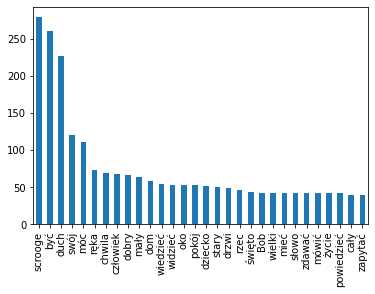

In [ ]:
freq_matrix_doc1 = countVectorizer.fit_transform(books[0])

freq_vect_doc1 = pd.DataFrame(data = freq_matrix_doc1.toarray(), columns=countVectorizer.get_feature_names())
print(freq_vect_doc1.head())

transponed_doc1 = freq_vect_doc1.T
transponed_doc1  = transponed_doc1.sort_values(by=[0], ascending=False)
transponed_doc1[:30].plot.bar(legend=None)


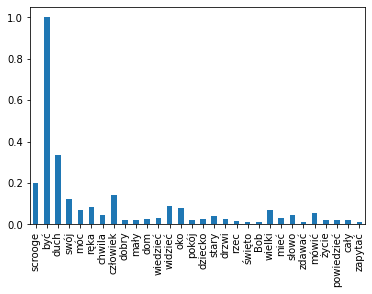

In [ ]:
 pd.DataFrame(data=[1.0/wordRank[word] for word in transponed_doc1.index], index=transponed_doc1.index, columns=['rank'])[:30]\
 .plot.bar(legend=None)

**Dokument nr2**

   Aleksandra  Allan  BN  Bolesław  Edgar  ...  żywiec  żywotny  żywy  żyć  żądza
0           1      2   1         1      2  ...       1        1     1    1      1

[1 rows x 1920 columns]


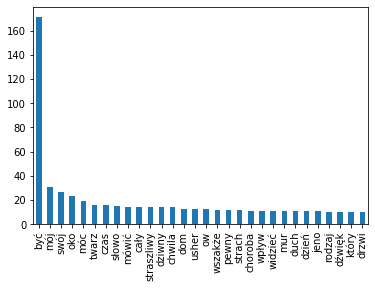

In [ ]:
freq_matrix_doc2 = countVectorizer.fit_transform(books[1])

freq_vect_doc2 = pd.DataFrame(data = freq_matrix_doc2.toarray(), columns=countVectorizer.get_feature_names())
print(freq_vect_doc2.head())

transponed_doc2 = freq_vect_doc2.T
transponed_doc2  = transponed_doc2.sort_values(by=[0], ascending=False)
transponed_doc2[:30].plot.bar(legend=None)


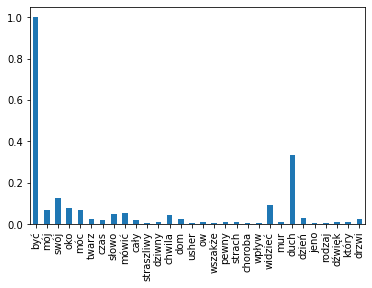

In [ ]:
 pd.DataFrame(data=[1.0/wordRank[word] for word in transponed_doc2.index], index=transponed_doc2.index, columns=['rank'])[:30]\
 .plot.bar(legend=None)

**Dokument nr3**

   Abraham  Adam  Aleksander  Aleksandra  BN  ...  żyć  żółtawo  żółty  żądać  żądza
0        1     2           2           1   1  ...   30        1      1      6      1

[1 rows x 3069 columns]


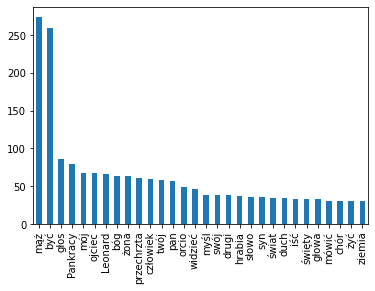

In [ ]:
freq_matrix_doc3 = countVectorizer.fit_transform(books[2])

freq_vect_doc3 = pd.DataFrame(data = freq_matrix_doc3.toarray(), columns=countVectorizer.get_feature_names())
print(freq_vect_doc3.head())

transponed_doc3 = freq_vect_doc3.T
transponed_doc3  = transponed_doc3.sort_values(by=[0], ascending=False)
transponed_doc3[:30].plot.bar(legend=None)


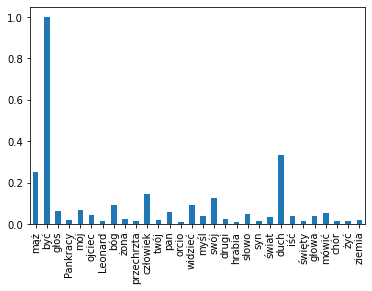

In [ ]:
 pd.DataFrame(data=[1.0/wordRank[word] for word in transponed_doc3.index], index=transponed_doc3.index, columns=['rank'])[:30]\
 .plot.bar(legend=None)

**Dokument nr4**

   Al  Aleksandra  Ante  BN  Beda  ...  żyć  żądać  żądza  żłopają  żłopać
0   1           1     1   1     2  ...   17      1      1        1       1

[1 rows x 4163 columns]


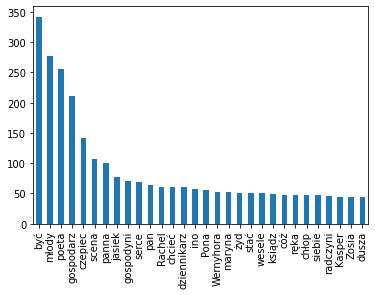

In [ ]:
freq_matrix_doc4 = countVectorizer.fit_transform(books[3])

freq_vect_doc4 = pd.DataFrame(data = freq_matrix_doc4.toarray(), columns=countVectorizer.get_feature_names())
print(freq_vect_doc4.head())

transponed_doc4 = freq_vect_doc4.T
transponed_doc4  = transponed_doc4.sort_values(by=[0], ascending=False)
transponed_doc4[:30].plot.bar(legend=None)


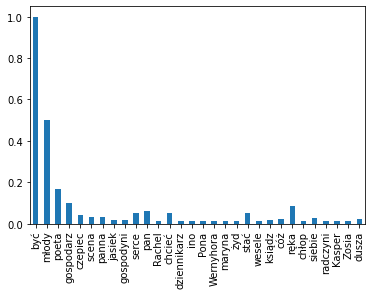

In [ ]:
 pd.DataFrame(data=[1.0/wordRank[word] for word in transponed_doc4.index], index=transponed_doc4.index, columns=['rank'])[:30]\
 .plot.bar(legend=None)

**Dokument nr5**

   Adam  Afryka  Aleksandra  Anna  Antoniusz  ...  żółw  żółć  żądać  żądza  żądło
0     3       1           1     1          1  ...     1     1      2      2      2

[1 rows x 3841 columns]


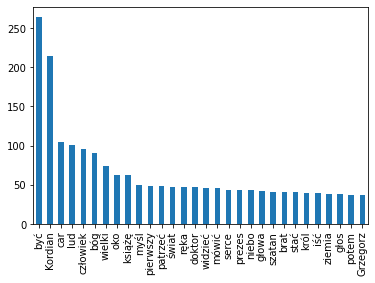

In [ ]:
freq_matrix_doc5 = countVectorizer.fit_transform(books[4])
freq_vect_doc5 = pd.DataFrame(data = freq_matrix_doc5.toarray(), columns=countVectorizer.get_feature_names())
print(freq_vect_doc5.head())

transponed_doc5 = freq_vect_doc5.T
transponed_doc5  = transponed_doc5.sort_values(by=[0], ascending=False)
transponed_doc5[:30].plot.bar(legend=None)


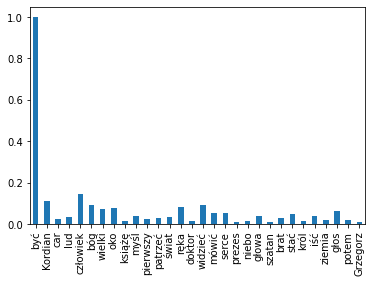

In [ ]:
 pd.DataFrame(data=[1.0/wordRank[word] for word in transponed_doc5.index], index=transponed_doc5.index, columns=['rank'])[:30]\
 .plot.bar(legend=None)

**Komentarz**: Na podstawie utworzonych wykresow bazujacych na poszczegolnych ksiazkach oraz na korpusie skladajacym sie z 5 książek doszedłem do kilku wniosków. 
* Wykresy wykonane dla 30 topowych wyrazow dla danej ksiazki mają tendencje spadkowa aczkolwiek w przypadku wykresu 1/ranking nie jest ona tak wyrazna jak w przypadku zliczaniu slow. Mozna zauwazyc korelacje pomiedzy wykresami co w mojej opini potwierdza prawo Zipfa. Niestety nie jest to silnie widoczne dla żadnej z wybranych książek. Wpływ na taki stan rzeczy może mieć wiele czynników takich jak np. stworzenie korpusu z książek mocno różniących się od siebie (np pod wzgledem epoki, stylu, itp).
* Powyzsza obserwacja odnosni sie do kazdej z 5 pozycji.
* Slowo 'być' jest najczęściej powtarzajacym sie slowem niemal w każdej książce.
* Najbardziej 'niepasujacymi' slowami są wszelkiego rodzaju słowa specyficzne dla danej książki jak imiona, nazwiska itp. 


#Utworzenie macierzy <b>podobieństwa kosinusowego</b> dokumentów

In [ ]:
flat_books = [item for sublist in books for item in sublist]

In [ ]:
countVectorizer = CountVectorizer(tokenizer=spacy_tokenizer) #powoluje drugi raz aby oddzielic poszczegolne ksiazki od wszystkich
freq_matrix_end = countVectorizer.fit_transform(flat_books)
freq_vect = pd.DataFrame(data = freq_matrix_end.toarray(), columns=countVectorizer.get_feature_names())


In [ ]:
freq_vect

,Abel,Abraham,Adam,Afryka,Al,Aleksander,Aleksandra,Allan,Anda,Anna,Ante,Antoniusz,Art,BN,Balladyna,Baltazar,Baszkir,Beda,Bella,Berno,Białe,Biega,Blanc,Bob,Bogarodzica,Bolesław,Bonaparte,Boże,Branecki,Brutus,Błażek,CAF,Cała,Charles,Chopin,Choromańska,Chrystus,Ciężkie,Crusoe,Cyla,...,żurawiec,żuć,żwir,życie,życiowy,życzenie,życzliwie,życzliwość,życzliwy,życzyć,żyd,żydowski,żyjący,żyrdź,żyto,żywie,żywiec,żywioł,żywiuteńki,żywić,żywnie,żywność,żywo,żywot,żywotny,żywość,żywy,żyzny,żyć,żyźnić,żółtawo,żółty,żółw,żółć,żądanie,żądać,żądza,żądło,żłopają,żłopać
0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,43,0,0,0,0,0,0,0,0,0,2,0,1,0,0,2,0,...,0,0,0,43,1,8,2,1,2,17,0,0,1,0,0,0,0,0,1,1,1,0,3,0,0,1,2,0,11,0,0,2,0,0,2,2,1,0,0,0
1,0,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0,1,2,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,5,0,0,0,...,0,0,1,24,0,2,0,0,0,3,5,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,6,0,30,0,1,1,0,0,0,6,1,0,0,0
3,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,2,0,1,0,1,0,0,1,0,1,1,3,0,1,1,1,0,1,0,0,1,0,2,...,2,1,0,6,0,0,0,0,0,3,50,1,0,1,1,2,0,0,0,1,0,0,6,0,0,0,14,0,17,0,0,0,0,0,0,1,1,0,1,1
4,0,0,3,1,0,0,1,0,0,1,0,1,0,1,1,1,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,...,0,0,0,26,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,0,0,0,0,2,0,0,2,1,18,1,0,2,1,1,0,2,2,2,0,0


#Przekształcenie macierzy liczby tokenów w <b>znormalizowaną</b> reprezenrtację TF-IDF - <b>TfidfTransformer()</b>

In [ ]:
tfidf_vectorizer = TfidfTransformer()

In [ ]:
TF_Idf = tfidf_vectorizer.fit_transform(freq_matrix_end.toarray())

ifidf_vect = pd.DataFrame(data = TF_Idf.toarray(), columns=countVectorizer.get_feature_names())
ifidf_vect

,Abel,Abraham,Adam,Afryka,Al,Aleksander,Aleksandra,Allan,Anda,Anna,Ante,Antoniusz,Art,BN,Balladyna,Baltazar,Baszkir,Beda,Bella,Berno,Białe,Biega,Blanc,Bob,Bogarodzica,Bolesław,Bonaparte,Boże,Branecki,Brutus,Błażek,CAF,Cała,Charles,Chopin,Choromańska,Chrystus,Ciężkie,Crusoe,Cyla,...,żurawiec,żuć,żwir,życie,życiowy,życzenie,życzliwie,życzliwość,życzliwy,życzyć,żyd,żydowski,żyjący,żyrdź,żyto,żywie,żywiec,żywioł,żywiuteńki,żywić,żywnie,żywność,żywo,żywot,żywotny,żywość,żywy,żyzny,żyć,żyźnić,żółtawo,żółty,żółw,żółć,żądanie,żądać,żądza,żądło,żłopają,żłopać
0,0.002365,0.001908,0.000000,0.000000,0.000000,0.000000,0.001127,0.000000,0.002365,0.000000,0.000000,0.000000,0.002365,0.000000,0.000000,0.001908,0.000000,0.000000,0.002365,0.000000,0.000000,0.000000,0.000000,0.101714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004731,0.000000,0.002365,0.000000,0.000000,0.004731,0.000000,...,0.000000,0.000000,0.000000,0.048467,0.001908,0.015267,0.004731,0.002365,0.004731,0.026931,0.000000,0.000000,0.001908,0.000000,0.000000,0.000000,0.000000,0.000000,0.002365,0.001908,0.002365,0.000000,0.005725,0.000000,0.000000,0.002365,0.002254,0.000000,0.012399,0.000000,0.000000,0.003168,0.000000,0.000000,0.004731,0.002665,0.001127,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004187,0.017573,0.000000,0.000000,0.000000,0.000000,0.000000,0.004950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008786,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.008373,0.007089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007089,0.000000,0.004187,0.000000,0.004187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004187,0.000000,0.000000,0.000000
2,0.000000,0.002640,0.005281,0.000000,0.000000,0.006546,0.001560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005281,0.000000,0.000000,0.000000,0.000000,0.003273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013202,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.003273,0.037428,0.000000,0.005281,0.000000,0.000000,0.000000,0.006575,0.010959,0.000000,0.002640,0.000000,0.000000,0.000000,0.002640,0.000000,0.000000,0.000000,0.000000,0.003273,0.000000,0.000000,0.002640,0.000000,0.009357,0.000000,0.046785,0.000000,0.003273,0.002192,0.000000,0.000000,0.000000,0.011063,0.001560,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.002111,0.000000,0.001006,0.000000,0.000000,0.000000,0.002111,0.000000,0.000000,0.001190,0.000000,0.000000,0.000000,0.004223,0.000000,0.002111,0.000000,0.002111,0.000000,0.000000,0.001704,0.000000,0.002111,0.002111,0.006334,0.000000,0.002111,0.002111,0.002111,0.000000,0.002111,0.000000,0.000000,0.002111,0.000000,0.004223,...,0.004223,0.002111,0.000000,0.006037,0.000000,0.000000,0.000000,0.000000,0.000000,0.004242,0.070703,0.002111,0.000000,0.002111,0.002111,0.004223,0.000000,0.000000,0.000000,0.001704,0.000000,0.000000,0.010221,0.000000,0.000000,0.000000,0.014086,0.000000,0.017104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001190,0.001006,0.000000,0.002111,0.002111
4,0.000000,0.000000,0.006848,0.002829,0.000000,0.000000,0.001348,0.000000,0.000000,0.002829,0.000000,0.002829,0.000000,0.001594,0.002829,0.002283,0.011316,0.000000,0.000000,0.000000,0.002829,0.000000,0.002829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013695,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.035050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011316,0.000000,0.

In [ ]:
cosine_similarities = np.asarray([linear_kernel(i[0], TF_Idf)[0] for i in TF_Idf])

label = [f'Dock: {i}'for i in range(0,cosine_similarities.shape[0]  )]
cosine_similarities
pd.DataFrame(data=cosine_similarities, index=label, columns=label)

,Dock: 0,Dock: 1,Dock: 2,Dock: 3,Dock: 4
Dock: 0,1.000000,0.388184,0.305120,0.225346,0.267719
Dock: 1,0.388184,1.000000,0.413133,0.318952,0.372903
Dock: 2,0.305120,0.413133,1.000000,0.293066,0.376485
Dock: 3,0.225346,0.318952,0.293066,1.000000,0.272145
Dock: 4,0.267719,0.372903,0.376485,0.272145,1.000000


Komentarz: Analizując powyższą tabele przed dokonaniem redukcji wymiarowości możemy zauważyć, że:
* **Największe** podobieństwo występuje w przypadku pozycji **1 oraz 2**
* **Najmniejsze** podobieństwo występuje w przypadku pozycji **0 oraz 3**

#Przeprowadzenie <b>redukcji wymiarowości</b> wymiarów macierzy TF-IDF do 2 wymiarów oraz wizualizacja położenia w układzie XY

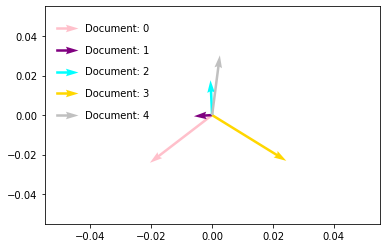

In [ ]:
pca = PCA(n_components=2,svd_solver='full')
pca.fit(TF_Idf.toarray())
X = pca.transform(TF_Idf.toarray())

origin = np.array([[0,0,0,0,0],[0,0,0,0,0]])
colors= ['pink','purple','cyan', 'gold','silver']

q = plt.quiver(*origin,X[:,0],X[:,1],color=colors, scale=3)
for i in range(X.shape[0]):
  plt.quiverkey(q,0.1 , 0.9 - i* 0.1 , 0.2,label='Document: ' + str(i), color=colors[i],labelpos='E') 


**Komentarz**: Na podstawie powyższego wykresu mogę wyciągnąć kilka wniosków
* **Najmniejszy kąt** występuję pomiędzy dokumentem **1 i dokumentem 2**
* Co ciekawe książki te to "Nie boska komedia" oraz "Zaglada domu Usherow" które zostały wydane w bardzo zbliżonym czasie - różni je zaledwie 4 lata.
* **Największy kąt** to ten pomiędzy dokumentem **3 oraz 0.**
* Powyższa wizualiazcja potwierdziła wyniki uzyskane w tabeli podobieństwa przed redukcją wymiarowości - wyniki są spójne.